# Machine Learning Engineer Nanodegree
## Capstone Project

In [1]:
import numpy as np
import os
import time
import re
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 

### Preprocess Data

In [2]:
replacement_patterns = [
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'ain\'t', 'is not'),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would')
]

class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns):
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    def replace(self, text):
        s = text
        for (pattern, repl) in self.patterns:
            (s, count) = re.subn(pattern, repl, s)
        regex = re.compile('[%s]' % re.escape(string.punctuation))
        s = regex.sub('', s)
        return s

In [3]:
# function for preprocessing the text
def common_preprocessing(text):
    '''
    Includes common preprocessing tasks on text data -lowercasing, term expansion, spelling correction, repeated chars removal
    '''
    
    # convert to lowercase
    text = text.lower()
    
    # expand abbreviation, eg. won't -> will not, we've -> we have, etc
    term_expander = RegexpReplacer()
    text = term_expander.replace(text)
    
    # remove numbers and special characters
    text = re.sub('[^A-Za-z ]+', '', text)
    tokens = text.split()
    
    # remove Stopwords
    tokens = [i for i in tokens if i not in stopwords.words('english')]
    text = ' '.join(tokens)
    return text

In [4]:
# function for building the training and testing dataset
def build_data(folder):
    data = []
    label = []
    filelist1 = []
    filelist2 = []
    count1 = 1
    count2 = 1
    pos_path = '%s/pos' % (folder)
    neg_path = '%s/neg' % (folder)
    for root,dirs,files in os.walk(pos_path):
        filelist1.extend(files)
        break
    for files in filelist1:
        try:
            f=open(pos_path + '/' + files, 'r')
            for line in f:
                data.append(common_preprocessing(line))
                label.append('1')
        except:
            continue
    print(len(data))        
    
    for root,dirs,files in os.walk(neg_path):
        filelist2.extend(files)
        break
    for files in filelist2:
        try:
            f=open(neg_path + '/' + files, 'r') 
            for line in f:
                data.append(common_preprocessing(line))
                label.append('0')
        except:
            continue
    print(len(data))          
    
    return data,label

In [5]:
# get the train data and train labels
start_time = time.time()
train_data, train_label = build_data('train_data')
print(time.time() - start_time)

12489
24984
2309.0333063602448


In [6]:
# get the test data and test labels
start_time = time.time()
test_data, test_label = build_data('test_data')
print(time.time() - start_time)

12493
24985
2242.1974337100983


### Data Exploration

Review length: 
Mean 842.59 words


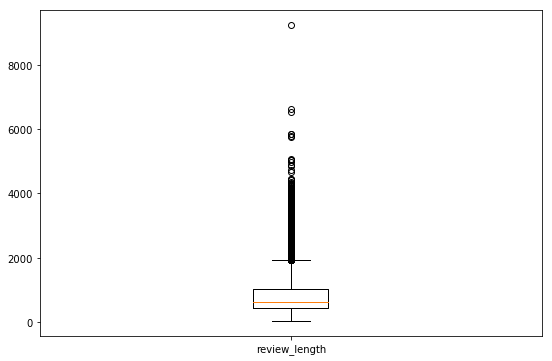

In [9]:
# summrize review length
print("Review length: ")
result = [len(x) for x in train_data]
print("Mean %.2f words" % (np.mean(result)))

fig = plt.figure(1, figsize=(9, 6))
plt.boxplot(result)
plt.xticks([1],['review_length'])
plt.show()

### Bench Mark Model

In [29]:
# vectorize data using TF-IDF weights
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train = tfidf_vectorizer.fit_transform(train_data) 

In [30]:
# build a benmark model
classifier =LogisticRegression().fit(X_train, train_label)
score = accuracy_score(test_label, classifier.predict(tfidf_vectorizer.transform(test_data)))
print("The accuracy of the Logistic Regression model is {0}%".format(round(score*100,0)))

The accuracy of the Logistic Regression model is 88.0%


### LSTM Model

In [10]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Embedding, LSTM
from keras import optimizers
from keras.callbacks import ModelCheckpoint

tokenizer = Tokenizer(num_words=20000, split=' ')
tokenizer.fit_on_texts(train_data)
train_data_vec = tokenizer.texts_to_sequences(train_data)
train_data_vec = pad_sequences(train_data_vec, maxlen=1000)

Using TensorFlow backend.


In [11]:
# split training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(train_data_vec, train_label, stratify=train_label, test_size = 0.4, random_state = 42)
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)

X_train shape: (14990, 1000)
X_valid shape: (9994, 1000)


In [23]:
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=train_data_vec.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='rmsprop',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 128)         2560000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,691,713.0
Trainable params: 2,691,713.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [24]:
epochs = 3
checkpointer = ModelCheckpoint(filepath='saved_model/lstm.hdf5', verbose=1, save_best_only=True)

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          epochs=epochs, batch_size=128, callbacks=[checkpointer], verbose=2)

Train on 14990 samples, validate on 9994 samples
Epoch 1/3
Epoch 00000: val_loss improved from inf to 0.33001, saving model to saved_model/lstm.hdf5
5860s - loss: 0.4901 - acc: 0.7735 - val_loss: 0.3300 - val_acc: 0.8623
Epoch 2/3
Epoch 00001: val_loss did not improve
6705s - loss: 0.2777 - acc: 0.8957 - val_loss: 0.3379 - val_acc: 0.8593
Epoch 3/3
Epoch 00002: val_loss improved from 0.33001 to 0.32836, saving model to saved_model/lstm.hdf5
7202s - loss: 0.2070 - acc: 0.9262 - val_loss: 0.3284 - val_acc: 0.8837


In [25]:
model.load_weights('saved_model/lstm.hdf5')
X_test = tokenizer.texts_to_sequences(test_data)
X_test = pad_sequences(X_test, maxlen=1000)
score = model.evaluate(X_test, test_label, verbose=0)

In [27]:
print("The accuracy of the LSTM model is {0}%".format(round(score[1]*100,0)))

The accuracy of the LSTM model is 87.0%


### Refined LSTM Model 

In [93]:
tokenizer = Tokenizer(num_words=15000, split=' ')
tokenizer.fit_on_texts(train_data)
train_data_vec = tokenizer.texts_to_sequences(train_data)
train_data_vec = pad_sequences(train_data_vec, maxlen=800)

In [94]:
# split training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(train_data_vec, train_label, stratify=train_label, test_size = 0.5, random_state = 42)
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)

X_train shape: (12492, 800)
X_valid shape: (12492, 800)


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=256, input_length=train_data_vec.shape[1]))
model.add(Dropout(0.2))
# model.add(Conv1D(64, 2, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.3))
model.add(LSTM(128, dropout=0.4, return_sequences=True))
model.add(LSTM(128, dropout=0.4, return_sequences=True))
model.add(LSTM(128, dropout=0.4))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

rmsprop = optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss = 'binary_crossentropy', optimizer=rmsprop, metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 800, 256)          5120000   
_________________________________________________________________
dropout_45 (Dropout)         (None, 800, 256)          0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 800, 128)          197120    
_________________________________________________________________
lstm_22 (LSTM)               (None, 800, 128)          131584    
_________________________________________________________________
lstm_23 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 129       
Total para

In [ ]:
epochs = 10
checkpointer = ModelCheckpoint(filepath='saved_model/lstm_conv.hdf5', verbose=1, save_best_only=True)

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=2)

Train on 12492 samples, validate on 12492 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 0.34568, saving model to saved_model/lstm_conv.hdf5
4144s - loss: 0.4579 - acc: 0.7806 - val_loss: 0.3457 - val_acc: 0.8555
Epoch 2/10
Epoch 00001: val_loss improved from 0.34568 to 0.29079, saving model to saved_model/lstm_conv.hdf5
3481s - loss: 0.2637 - acc: 0.8982 - val_loss: 0.2908 - val_acc: 0.8791
Epoch 3/10
Epoch 00002: val_loss did not improve
3900s - loss: 0.2115 - acc: 0.9226 - val_loss: 0.3126 - val_acc: 0.8793
Epoch 4/10
Epoch 00003: val_loss did not improve
3864s - loss: 0.1749 - acc: 0.9356 - val_loss: 0.3014 - val_acc: 0.8812
Epoch 5/10


In [91]:
model.load_weights('saved_model/lstm_conv.hdf5')
X_test = tokenizer.texts_to_sequences(test_data)
X_test = pad_sequences(X_test, maxlen=1000)
score = model.evaluate(X_test, test_label, verbose=0)

In [92]:
score

[0.34021845857143307, 0.86251751048006198]